In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# astronomical units and constants
import astropy.units as u
from astropy.constants import R_sun


from matplotlib.lines import Line2D

import os
CWD = "/".join(os.getcwd().split("/")[:-2])
# Plot stuff
from funcs.model import full_model, full_model_coupled, aflare_decoupled, aflare

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable


from funcs.helper import fetch_lightcurve
from funcs.multiperiod import find_period
from scipy import optimize

def cosine(x, a, b, c, d, e):
    """cosine with a linear trend"""
    return a * np.cos(b * x + c) + d * x + e

In [7]:
# Datasets we analysed
datasets = [
            (452922110, "", "29_10_2020_10_58"),
            (44984200, "", "30_10_2020_07_13"),
        (277539431, "", "30_10_2020_11_30")
            ]

7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 452922110 modulation period:  4.232851873935665 h
Relative amplitude of modulation: -5.8e-03
TIC 44984200 modulation period:  2.7114843822240977 h
Relative amplitude of modulation: 4.9e-03
TIC 277539431 modulation period:  4.556764823311947 h
Relative amplitude of modulation: 5.4e-03


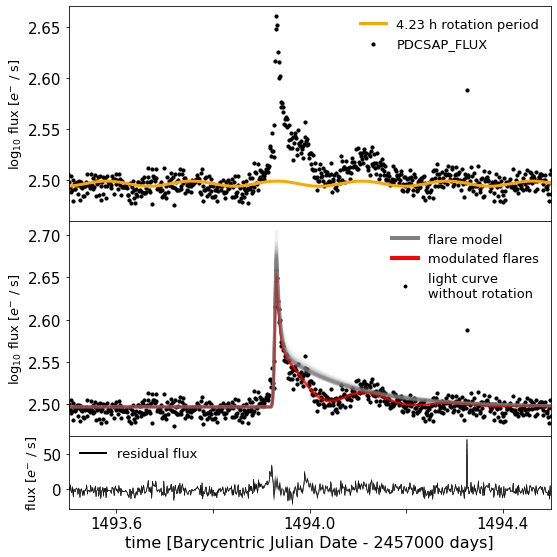

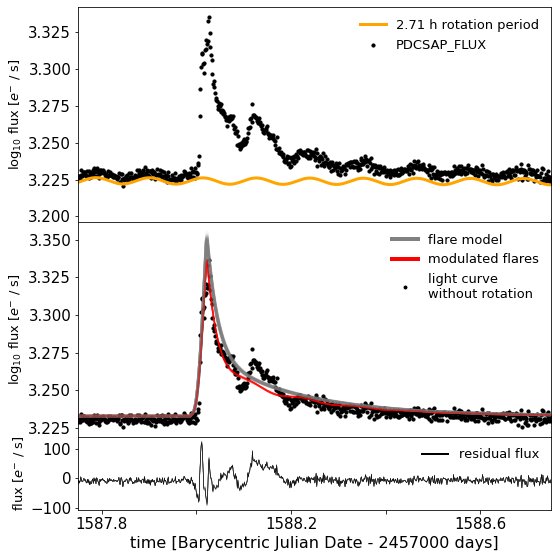

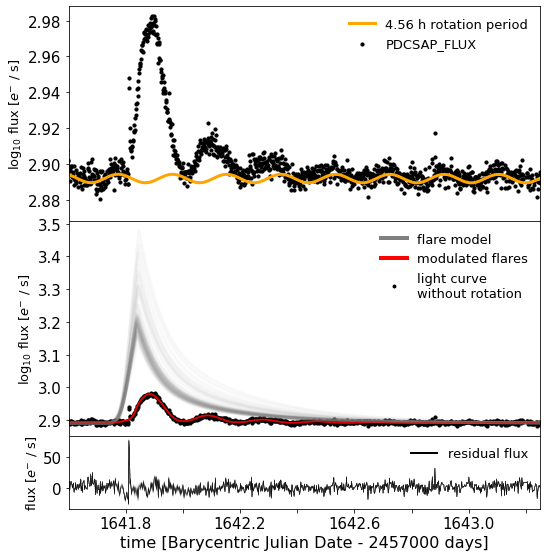

In [8]:


for ID, suffix, tstamp in datasets:

    # Get data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits_decoupled.csv")
    inits = inits[(inits.ID.astype(str) == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun

    # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    inds = np.random.randint(df.shape[0], size=N)
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")

    for ind in inds:
        sample = df.loc[ind,]

        a = sample.a
        phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
        theta_a = sample.latitude_deg / 180 * np.pi
        fwhm1 = sample.fwhm1_d / target.Prot_d * 2 * np.pi
        fwhm2 = sample.fwhm2_d / target.Prot_d * 2 * np.pi
        i = sample.i_deg / 180 * np.pi
        
        phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
        flare = aflare_decoupled(phi, phi_a, (fwhm1,fwhm2), a*median)+ median
        fullmodel = full_model(phi_a, theta_a, a, fwhm1, fwhm2, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel) , c="r", alpha=0.05)
        ax2.plot(time, flux-fullmodel, c="k", alpha=.05, linewidth=.5)

   # ax.set_ylim(2.8,3.0)

    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
             label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, np.log10(model),linewidth=3,
                 c="orange",label=f"{period:.2f} rotation period")    
    ax3.legend(loc=1, frameon=False, fontsize=13)


    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                       Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [
                       Line2D([0], [0], color='k', lw=2, label="residual flux"),
                      ]




    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    #ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    #ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/"
#                 f"{tstamp}_Nature_{target.prefix}{target.ID}.png",
#                 dpi=300)

In [45]:
# Datasets we analysed
datasets = [
           (44984200,  "30_10_2020_07_14"),
            ]

TIC 44984200 modulation period:  2.7114843822240977 h
Relative amplitude of modulation: 4.9e-03


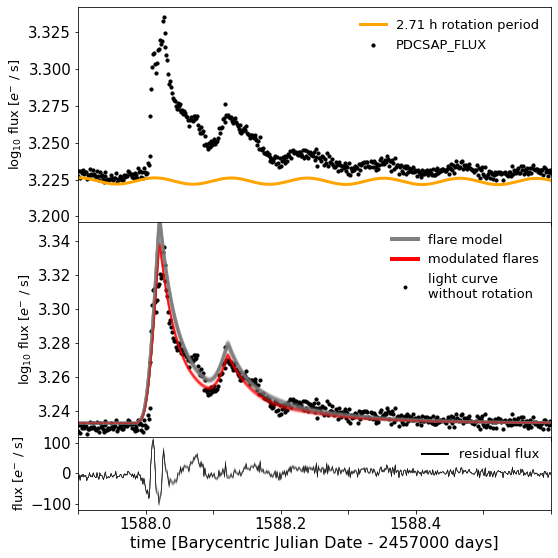

In [46]:
for ID, tstamp in datasets:

    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
     # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")
    
    #--------------------------------------------------------------
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits_decoupled.csv")#_decoupled
    #--------------------------------------------------------------
    dfa = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}a_converted_mcmc_sample.csv")#[1000:].reset_index()
    dfb = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}b_converted_mcmc_sample.csv")#[1000:].reset_index()
    
    ddic = {"a":dfa,"b":dfb}

    inds = np.random.randint(dfa.shape[0], size=N)

    for ind in inds:
        inits_ = inits[(inits.ID == str(ID)+"a") & (inits.tstamp==tstamp)].iloc[0]
        median = inits_['median']
        flare = np.full(len(phi), median,)
        fullmodel = np.full(len(phi), median)
        for suffix in ["a", "b"]:
            # Get data
            df = ddic[suffix]
            
            inits_ = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

            qlum = inits_.qlum_erg_s * u.erg / u.s
            Fth = inits_.Fth * u.erg/ u.cm**2 / u.s
            median = inits_['median']
            R = inits_.R_Rsun * R_sun


            sample = df.loc[ind,]

            a = sample.a
            phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
            theta_a = sample.latitude_deg / 180 * np.pi
            fwhm1 = sample.fwhm1_d / target.Prot_d * 2 * np.pi
            fwhm2 = sample.fwhm2_d / target.Prot_d * 2 * np.pi
            i = sample.i_deg / 180 * np.pi
            if suffix=="a":
                phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
            flare = aflare_decoupled(phi, phi_a, (fwhm1, fwhm2), a*median)+ flare
        
            fullmodel = full_model(phi_a, theta_a, a, fwhm1,fwhm2, i, phi0=phi0,
                                   phi=phi, num_pts=50, qlum=qlum,
                                   Fth=Fth, R=R, median=median) + fullmodel
            
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel-2*median) , c="r", alpha=0.05)
        ax2.plot(time, flux-fullmodel+2*median, c="k", alpha=.05, linewidth=.5)


    ax2.set_ylim(-120,120)
    ax.set_ylim(3.225,3.351)

    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
             label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, np.log10(model),linewidth=3,
                 c="orange",label=f"{period:.2f} rotation period")    
    ax3.legend(loc=1, frameon=False, fontsize=13)


    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                       Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [Line2D([0], [0], color='k', lw=2, label="residual flux"),]


    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    #ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    #ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        
        axis.set_xlim(1587.9,1588.6)
    plt.savefig(f"{CWD}/analysis/plots/flarefit/"
                f"{tstamp}_{target.prefix}{target.ID}ab_decoupled_f.png",
                dpi=300)

In [47]:
datasets = [# (237880881, "03_10_2020_11_29"),
    (44984200,  "04_08_2020_13_40"),
            ]

TIC 44984200 modulation period:  2.7114843822240977 h
Relative amplitude of modulation: 4.9e-03


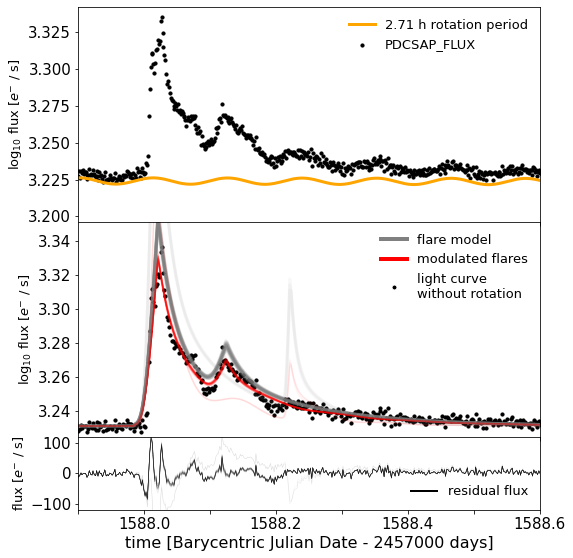

In [48]:
for ID, tstamp in datasets:

    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
     # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")
    
    #--------------------------------------------------------------
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")#_decoupled
    #--------------------------------------------------------------
    dfa = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}a_converted_mcmc_sample.csv")#[1000:].reset_index()
    dfb = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}b_converted_mcmc_sample.csv")#[1000:].reset_index()
    
    ddic = {"a":dfa,"b":dfb}

    inds = np.random.randint(dfa.shape[0], size=N)

    for ind in inds:
        inits_ = inits[(inits.ID == str(ID)+"a") & (inits.tstamp==tstamp)].iloc[0]
        median = inits_['median']
        flare = np.full(len(phi), median,)
        fullmodel = np.full(len(phi), median)
        for suffix in ["a", "b"]:
            # Get data
            df = ddic[suffix]
            
            inits_ = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

            qlum = inits_.qlum_erg_s * u.erg / u.s
            Fth = inits_.Fth * u.erg/ u.cm**2 / u.s
            median = inits_['median']
            R = inits_.R_Rsun * R_sun


            sample = df.loc[ind,]

            a = sample.a
            phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
            theta_a = sample.latitude_deg / 180 * np.pi
            fwhm = sample.fwhm_d / target.Prot_d * 2 * np.pi
            i = sample.i_deg / 180 * np.pi
            if suffix=="a":
                phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
            flare = aflare(phi, phi_a, fwhm, a*median)+ flare
        
            fullmodel = full_model_coupled(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                                   phi=phi, num_pts=50, qlum=qlum,
                                   Fth=Fth, R=R, median=median) + fullmodel
            
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel-2*median) , c="r", alpha=0.05)
        ax2.plot(time, flux-fullmodel+2*median, c="k", alpha=.05, linewidth=.5)
    ax2.set_ylim(-120,120)
    ax.set_ylim(3.225,3.351)
    ax.set_xlim(1587.8,1588.6)
    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
             label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, np.log10(model),linewidth=3,
                 c="orange",label=f"{period:.2f} rotation period")    
    ax3.legend(loc=1, frameon=False, fontsize=13)


    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                       Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [Line2D([0], [0], color='k', lw=2, label="residual flux"),]


    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    #ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    #ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        
        axis.set_xlim(1587.9,1588.6)
    plt.savefig(f"{CWD}/analysis/plots/flarefit/"
                f"{tstamp}_{target.prefix}{target.ID}ab_davenport_f.png",
                dpi=300)

# Nature Fig. 2: TIC 277

In [ ]:
# Datasets we analysed
datasets = [
            (277539431, "", "03_10_2020_11_30"),
            ]

In [ ]:


for ID, suffix, tstamp in datasets[:1]:

    # Get data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv").iloc[500000:].reset_index()
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun

    # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    inds = np.random.randint(df.shape[0], size=N)
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")

    for ind in inds:
        sample = df.loc[ind,]

        a = sample.a
        phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
        theta_a = 10 / 180 * np.pi #active close to the equator!
        fwhm = sample.fwhm_d / target.Prot_d * 2 * np.pi
        i = 90 / 180 * np.pi # choose equator-on view
        
        phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
        flare = aflare(phi, phi_a, fwhm, a*median)+ median
        fullmodel = full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel) , c="b", alpha=0.05)
        
        
        theta_a = sample.latitude_deg / 180 * np.pi
        i = sample.i_deg / 180 * np.pi
        fullmodel = full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, np.log10(fullmodel) , c="r", alpha=0.05)
        ax2.plot(time, flux-fullmodel, c="k", alpha=.05, linewidth=.5)

    ax.set_ylim(2.8,3.5)

    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
             label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, np.log10(model),linewidth=3,
                 c="orange",label=f"{period:.2f} rotation period")    
    ax3.legend(loc=1, frameon=False, fontsize=13)


    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flare"),
                       Line2D([0], [0], color='b', lw=4, label="same flare but at the equator"),
                       Line2D([0], [0], marker='o', color='w', label="light curve without rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [
                       Line2D([0], [0], color='k', lw=2, label="residual flux"),
                      ]




    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    #ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    #ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
    plt.savefig(f"{CWD}/analysis/plots/flarefit/"
                f"{tstamp}_Nature_{target.prefix}{target.ID}_from_equator.png",
                dpi=300)

In [ ]:


for ID, suffix, tstamp in datasets[:1]:

    # Get data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv").iloc[500000:].reset_index()
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun

    # Plot the results
    N = 100
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    inds = np.random.randint(df.shape[0], size=N)
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    ax.scatter(time, flux, s=10, c="k",label=r"de-trended light curve")

    for ind in inds:
        sample = df.loc[ind,]

        a = sample.a
        phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
        theta_a = 10 / 180 * np.pi #active close to the equator!
        fwhm = sample.fwhm_d / target.Prot_d * 2 * np.pi
        i = 90 / 180 * np.pi # choose equator-on view
        
        phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
        flare = aflare(phi, phi_a, fwhm, a*median)+ median
        fullmodel = full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, flare, c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, fullmodel , c="b", alpha=0.05)
        
        
        theta_a = sample.latitude_deg / 180 * np.pi
        i = sample.i_deg / 180 * np.pi
        fullmodel = full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, fullmodel , c="r", alpha=0.05)
        ax2.plot(time, flux-fullmodel, c="k", alpha=.05, linewidth=.5)

    #ax.set_ylim(2.8,3.5)

    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, flck.flux,c="k",s=10,
             label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, model,linewidth=3,
                 c="orange",label=f"{period:.2f} rotation period")    
    ax3.legend(loc=1, frameon=False, fontsize=13)


    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flare"),
                       Line2D([0], [0], color='b', lw=4, label=r"same flare but at $\theta_f=10^\circ$"),
                       Line2D([0], [0], marker='o', color='w', label="light curve without rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [
                       Line2D([0], [0], color='k', lw=2, label="residual flux"),
                      ]




    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    #ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    #ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
    plt.savefig(f"{CWD}/analysis/plots/flarefit/"
                f"{tstamp}_Nature_{target.prefix}{target.ID}_from_equator_nolog.png",
                dpi=300)

# Backlog

In [ ]:
8.8706892e+30 erg / s 90616286040.1588 erg / (cm2 s) 615.088583574826 191422550.70000002 m

In [ ]:
plt.plot(lc.flux)

In [ ]:
df.shape